In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import idx2numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Task 1

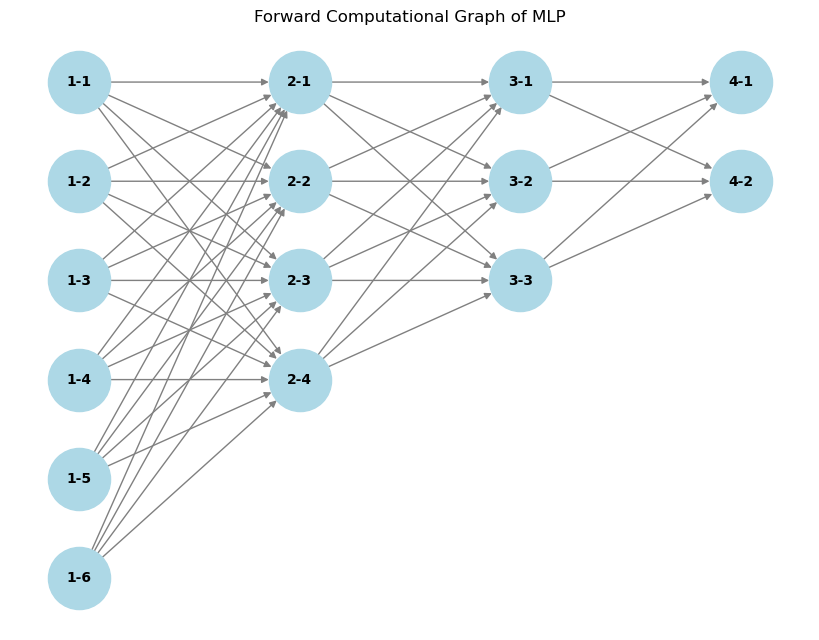

In [2]:
def draw_mlp_graph():
    layers = ["Input Layer", "Hidden Layer 1", "Hidden Layer 2", "Output Layer"]
    neurons = [6, 4, 3, 2]  # Given number of neurons per layer
    
    G = nx.DiGraph()
    node_positions = {}
    y_offset = 0
    node_labels = {}
    
    for layer_idx, (layer_name, num_neurons) in enumerate(zip(layers, neurons)):
        for i in range(num_neurons):
            node_id = f"{layer_idx+1}-{i+1}"
            G.add_node(node_id, layer=layer_idx)
            node_positions[node_id] = (layer_idx, -i + y_offset)
            node_labels[node_id] = node_id  # Label each neuron
        
    for l in range(len(layers) - 1):
        for i in range(neurons[l]):
            for j in range(neurons[l + 1]):
                G.add_edge(f"{l+1}-{i+1}", f"{l+2}-{j+1}")
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos=node_positions, with_labels=True, labels=node_labels, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Forward Computational Graph of MLP")
    plt.show()

draw_mlp_graph()

In [3]:
import numpy as np

class MLP:
    def __init__(self, layers, activation="relu", learning_rate=0.01):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_func = self.relu if activation == "relu" else self.sigmoid
        self.activation_deriv = self.relu_deriv if activation == "relu" else self.sigmoid_deriv
        
        # Initialize weights and biases
        self.weights = [np.random.randn(self.layers[i], self.layers[i - 1]) * np.sqrt(2 / self.layers[i - 1]) for i in range(1, len(layers))]
        self.biases = [np.zeros((n, 1)) for n in self.layers[1:]]
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_deriv(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Prevent overflow
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(w, self.activations[-1]) + b
            self.z_values.append(z)
            if i == len(self.weights) - 1:  # Last layer: use softmax
                self.activations.append(self.softmax(z))
            else:
                self.activations.append(self.activation_func(z))
        
        return self.activations[-1]
    
    def backward(self, X, Y):
        m = X.shape[1]
        dA = self.activations[-1] - Y  # Softmax derivative with cross-entropy
        gradients_w = []
        gradients_b = []
        
        for i in reversed(range(len(self.weights))):
            dZ = dA if i == len(self.weights) - 1 else dA * self.activation_deriv(self.z_values[i])
            dW = np.dot(dZ, self.activations[i].T) / m
            dB = np.sum(dZ, axis=1, keepdims=True) / m
            gradients_w.insert(0, dW)
            gradients_b.insert(0, dB)
            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)
        
        return gradients_w, gradients_b
    
    def update_parameters(self, gradients_w, gradients_b):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]
    
    def train(self, X, Y, epochs=1000):
        for epoch in range(epochs):
            self.forward(X)
            gradients_w, gradients_b = self.backward(X, Y)
            self.update_parameters(gradients_w, gradients_b)
            
            if epoch % 100 == 0:
                loss = -np.sum(Y * np.log(self.activations[-1] + 1e-8)) / X.shape[1]  # Categorical cross-entropy
                print(f"Epoch {epoch}, Loss: {loss}")

# Example Usage
np.random.seed(0)
mlp = MLP([6, 4, 3, 2], activation="relu")

# Dummy Data
X = np.random.randn(6, 5)  # 6 input features, 5 samples
Y = np.array([[0, 1, 0, 0, 1], [1, 0, 1, 1, 0]])  # One-hot encoded labels (2 classes, 5 samples)

mlp.train(X, Y, epochs=500)


Epoch 0, Loss: 0.6438889246629496
Epoch 100, Loss: 0.5179502007551731
Epoch 200, Loss: 0.4852156883215747
Epoch 300, Loss: 0.4694129538808352
Epoch 400, Loss: 0.4612659506761078


## Task 2

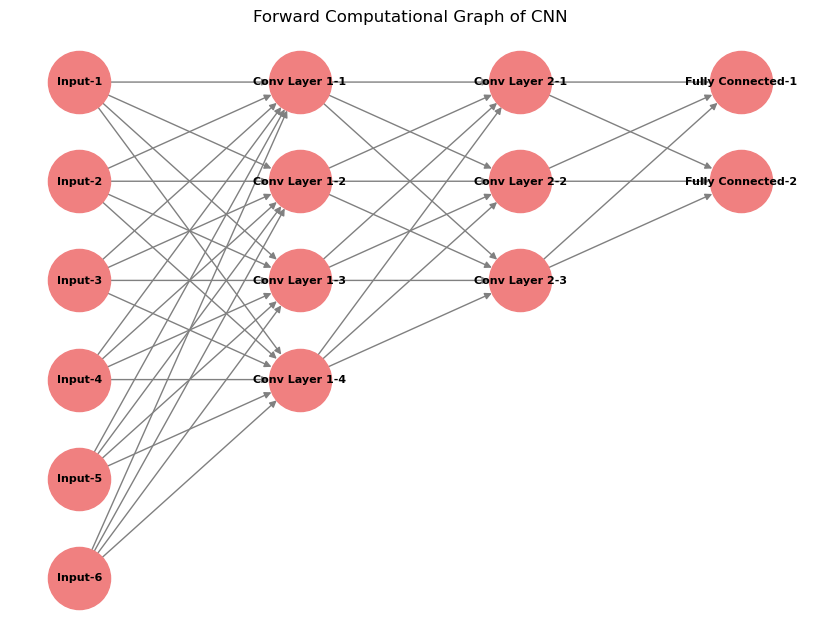

In [4]:
def draw_cnn_graph():
    G = nx.DiGraph()
    layers = ["Input", "Conv Layer 1", "Conv Layer 2", "Fully Connected"]
    neurons = [6, 4, 3, 2]
    node_positions = {}
    node_labels = {}
    
    for i, (layer, num) in enumerate(zip(layers, neurons)):
        for j in range(num):
            node_id = f"{layer}-{j+1}"
            G.add_node(node_id, layer=i)
            node_positions[node_id] = (i, -j)
            node_labels[node_id] = node_id
        
    for i in range(len(layers) - 1):
        for j in range(neurons[i]):
            for k in range(neurons[i + 1]):
                G.add_edge(f"{layers[i]}-{j+1}", f"{layers[i+1]}-{k+1}")
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos=node_positions, with_labels=True, labels=node_labels, node_size=2000, node_color='lightcoral', font_size=8, font_weight='bold', edge_color='gray')
    plt.title("Forward Computational Graph of CNN")
    plt.show()

draw_cnn_graph()

In [5]:
class CNN:
    def __init__(self, input_shape, num_filters, kernel_size, activation="relu"):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.activation_func = self.relu if activation == "relu" else self.sigmoid
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size) * 0.01
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def convolve(self, X):
        height, width = X.shape
        output = np.zeros((height - self.kernel_size + 1, width - self.kernel_size + 1, self.num_filters))
        
        for f in range(self.num_filters):
            for i in range(output.shape[0]):
                for j in range(output.shape[1]):
                    region = X[i:i+self.kernel_size, j:j+self.kernel_size]
                    output[i, j, f] = np.sum(region * self.filters[f])
        
        return self.activation_func(output)
    
    def forward(self, X):
        return self.convolve(X)
    
# Example Usage
cnn = CNN(input_shape=(28, 28), num_filters=3, kernel_size=3, activation="relu")
X_sample = np.random.randn(28, 28)
output = cnn.forward(X_sample)
print("CNN Output Shape:", output.shape)

CNN Output Shape: (26, 26, 3)


## Task 3
### MPL model

In [18]:
# File paths
train_images_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_images\t10k-images-idx3-ubyte"
train_labels_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_labels\t10k-labels-idx1-ubyte"

# Load images and labels
X = idx2numpy.convert_from_file(train_images_path)
Y = idx2numpy.convert_from_file(train_labels_path)

# Normalize pixel values (0-255 -> 0-1)
X = X.astype(np.float32) / 255.0

# Flatten images (28x28 -> 784)
X = X.reshape(X.shape[0], 28*28)

# One-hot encode labels
Y = to_categorical(Y, num_classes=10)

# Train-test split (80-20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 8000, Testing samples: 2000


In [13]:
# Define MLP model
model = Sequential([
    Dense(128, activation="relu", input_shape=(28*28,)),  
    Dense(64, activation="relu"),  
    Dense(10, activation="softmax")  
])

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/10
250/250 [==============================] - 2s 4ms/step - loss: 0.5623 - accuracy: 0.8356 - val_loss: 0.2733 - val_accuracy: 0.9190
Epoch 2/10
250/250 [==============================] - 1s 4ms/step - loss: 0.2154 - accuracy: 0.9346 - val_loss: 0.2167 - val_accuracy: 0.9380
Epoch 3/10
250/250 [==============================] - 1s 4ms/step - loss: 0.1448 - accuracy: 0.9576 - val_loss: 0.1901 - val_accuracy: 0.9455
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.1054 - accuracy: 0.9656 - val_loss: 0.1932 - val_accuracy: 0.9415
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0694 - accuracy: 0.9794 - val_loss: 0.1811 - val_accuracy: 0.9475
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.0487 - accuracy: 0.9852 - val_loss: 0.1924 - val_accuracy: 0.9465
Epoch 7/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0353 - accuracy: 0.9904 - val_loss: 0.1775 - val_accuracy: 0.9555
Epoch 

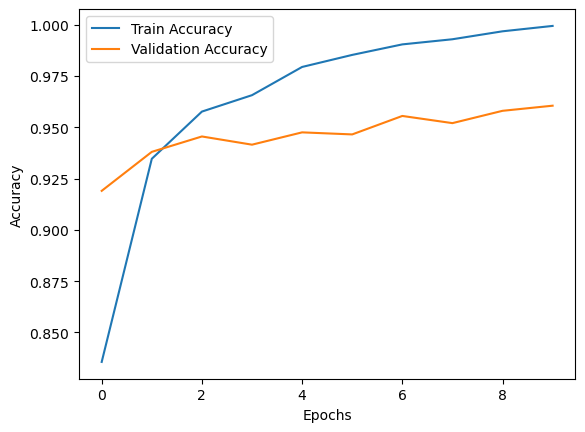

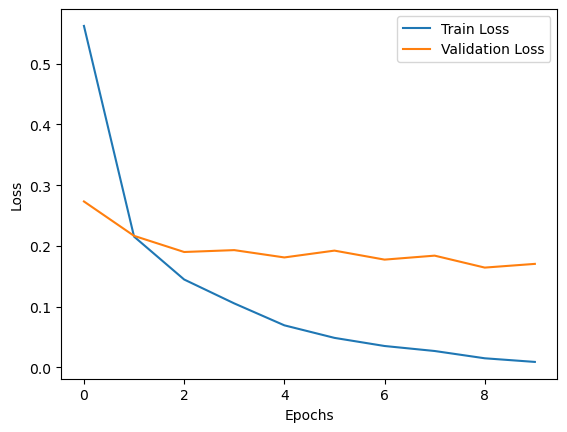

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

63/63 [==============================] - 0s 2ms/step


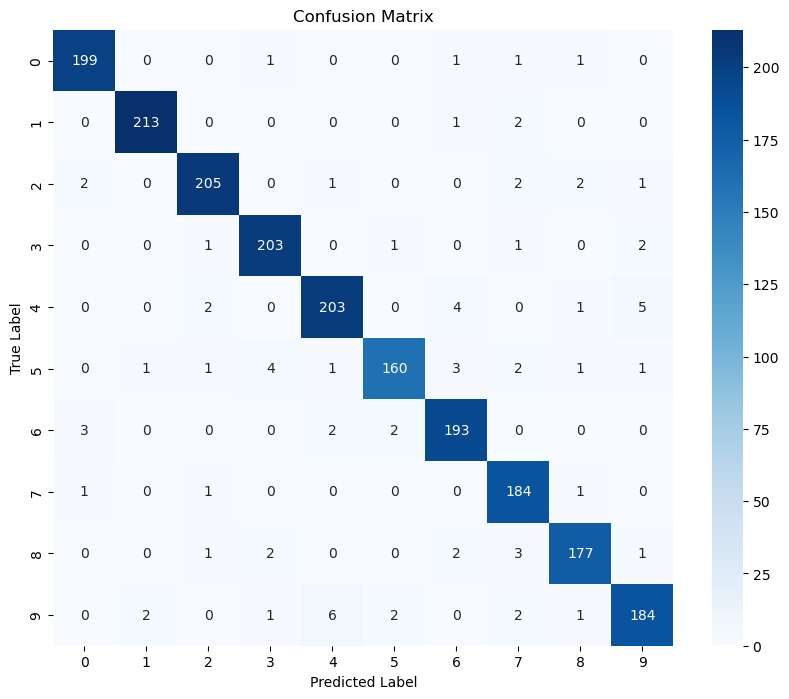

<Figure size 640x480 with 0 Axes>

In [ ]:
# Predict labels
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confuction_matrix_mpl.png')

### CNN

Epoch 1/10
250/250 [==============================] - 16s 59ms/step - loss: 0.3861 - accuracy: 0.8885 - val_loss: 0.1902 - val_accuracy: 0.9415
Epoch 2/10
250/250 [==============================] - 13s 50ms/step - loss: 0.0969 - accuracy: 0.9694 - val_loss: 0.1120 - val_accuracy: 0.9605
Epoch 3/10
250/250 [==============================] - 13s 53ms/step - loss: 0.0541 - accuracy: 0.9811 - val_loss: 0.1053 - val_accuracy: 0.9675
Epoch 4/10
250/250 [==============================] - 12s 50ms/step - loss: 0.0407 - accuracy: 0.9860 - val_loss: 0.1388 - val_accuracy: 0.9555
Epoch 5/10
250/250 [==============================] - 13s 54ms/step - loss: 0.0250 - accuracy: 0.9908 - val_loss: 0.0910 - val_accuracy: 0.9745
Epoch 6/10
250/250 [==============================] - 13s 51ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0754 - val_accuracy: 0.9795
Epoch 7/10
250/250 [==============================] - 12s 49ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.1229 - val_accuracy:

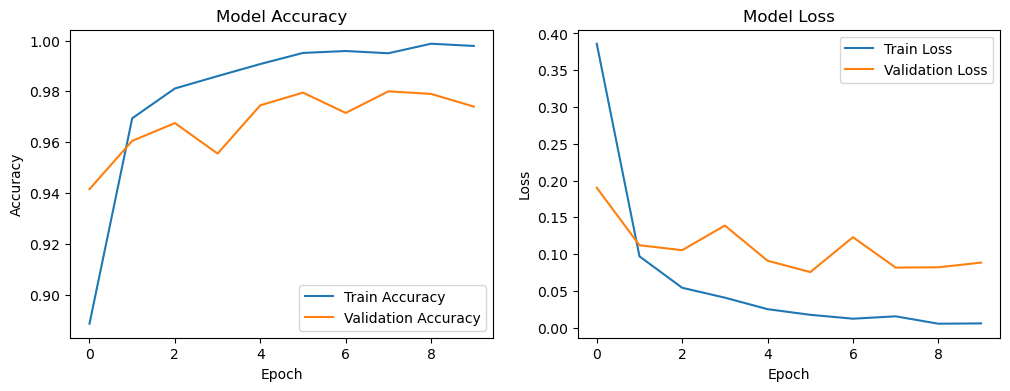

63/63 [==============================] - 2s 28ms/step


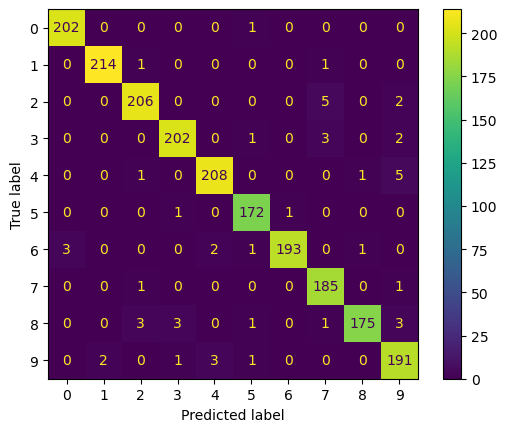

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import idx2numpy

# CNN Class
def create_cnn(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load MNIST dataset
train_images_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_images\t10k-images-idx3-ubyte"
train_labels_path = r"C:\Users\nkras\OneDrive - University of Copenhagen\Fysik\129L\sec9b\train_labels\t10k-labels-idx1-ubyte"

X = idx2numpy.convert_from_file(train_images_path)
Y = idx2numpy.convert_from_file(train_labels_path)

# Normalize and reshape
X = X.astype(np.float32) / 255.0
X = X.reshape(-1, 28, 28, 1)  # Reshape for CNN
Y = to_categorical(Y, num_classes=10)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train CNN
cnn_model = create_cnn()
history = cnn_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Confusion Matrix
Y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
Y_true = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
